# Analyze Dataset
---
1. Encode email data using BERT.
2. Split data into test and train splits.
3. Train an SVM model to predict the class of an email.
4. Test the model on unseen emails.

## Imports

In [25]:
from pathlib import Path
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import joblib
import platform
from pathlib import Path

## Load Data

In [26]:
email_dataframe = pd.read_feather("./data/2_balanced_email_dataset.feather")

# Encode "Email Type" into a numerical format: 0 for ham, 1 for phishing, and 2 for spam
email_dataframe["label_id"] = email_dataframe["Email Type"].astype("category").cat.codes

## Encode Email Text using SBERT

Activate CUDA if available.

In [27]:
if platform.system() in ["Windows", "Linux"]:
    device = "cuda" if torch.cuda.is_available() else "cpu"
elif platform.system() == "Darwin":
    device = "mps" if torch.backends.mps.is_available() else "cpu"
else:
    device = "cpu"

# Store the variable to be used in 5. Demo Classify Emails.ipynb
%store device

print("Using device:", device)

Stored 'device' (str)
Using device: cuda


## Load SBERT model and encode email data.

**NOTE:** This model is computationally expensive, even on GPU. It may take far longer if processed on CPU. If you have a Windows machine and CUDA is installed, it should be detected above and used in the loading process, reducing the computational load on the CPU.

In [28]:
Path("./models").mkdir(parents=True, exist_ok=True)

# Load a SBERT-based encoder
# sbert_model_type = "all-MiniLM-L6-v2"  # Use for 384-dimensional, fast but not as accurate
sbert_model_type = "all-mpnet-base-v2"  # 768-dimensional, best accuracy, but slightly slower to process

# Conditionally load sbert model or re-process it and then save it as a joblib file.
if Path("models/sbert.joblib").exists():
    sbert = joblib.load("./models/sbert.joblib")
else:
    sbert = SentenceTransformer(sbert_model_type, device=device)
    joblib.dump(sbert, "./models/sbert.joblib")

# Encode emails
X = sbert.encode(
    email_dataframe['Email Text'].tolist(),
    convert_to_numpy=True,
    batch_size=32,
    show_progress_bar=True
)

True


Batches:   0%|          | 0/1610 [00:00<?, ?it/s]

Encode email using SBERT

## Train SVM Model

In [29]:
# Labels
y = email_dataframe['label_id']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [33]:
# Train SVM classifier
clf = SVC(
    kernel="linear",
    class_weight="balanced",
    C=1.5
)

clf.fit(X_train, y_train)

# Save model as joblib file.
joblib.dump(clf, "./models/svm_model.joblib")

# Predict
y_pred = clf.predict(X_test)

In [31]:
# Results
target_names = email_dataframe["Email Type"].astype("category").cat.categories
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         ham       0.97      0.96      0.96      3434
       phish       0.96      0.97      0.96      3434
        spam       1.00      1.00      1.00      3435

    accuracy                           0.97     10303
   macro avg       0.97      0.97      0.97     10303
weighted avg       0.97      0.97      0.97     10303



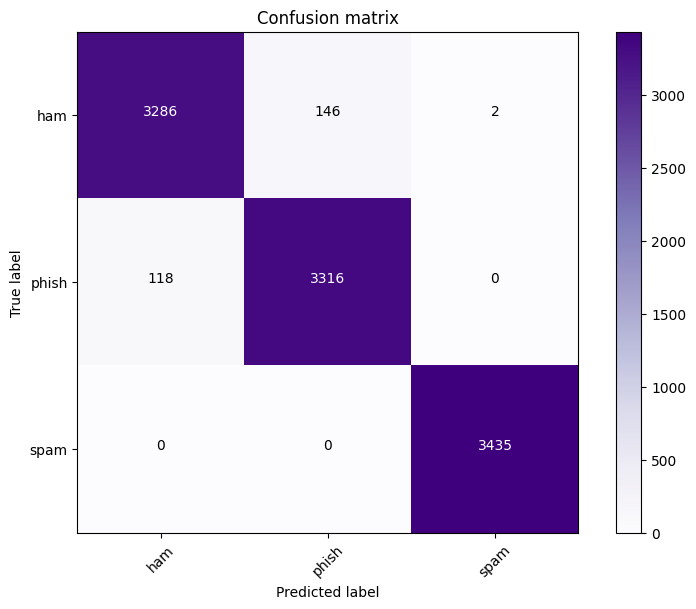

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
class_names = email_dataframe["Email Type"].unique()


plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
